##### Copyright 2018 The TensorFlow Authors.




In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Import Library

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import collections
import random
import numpy as np 
import pandas as pd
import os
from time import time
import json
from PIL import Image
import re
from pickle import dump, load
from tqdm import tqdm

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
%cd /content/drive/MyDrive/045195/Image Captioning/

/content/drive/MyDrive/045195/Image Captioning


# Flickr 8k dataset

In [4]:
df = pd.read_csv('./captions.txt')
df

image                                            caption
0      1000268201_693b08cb0e.jpg  A child in a pink dress is climbing up a set o...
1      1000268201_693b08cb0e.jpg              A girl going into a wooden building .
2      1000268201_693b08cb0e.jpg   A little girl climbing into a wooden playhouse .
3      1000268201_693b08cb0e.jpg  A little girl climbing the stairs to her playh...
4      1000268201_693b08cb0e.jpg  A little girl in a pink dress going into a woo...
...                          ...                                                ...
40450   997722733_0cb5439472.jpg           A man in a pink shirt climbs a rock face
40451   997722733_0cb5439472.jpg           A man is rock climbing high in the air .
40452   997722733_0cb5439472.jpg  A person in a red shirt climbing up a rock fac...
40453   997722733_0cb5439472.jpg                    A rock climber in a red shirt .
40454   997722733_0cb5439472.jpg  A rock climber practices on a rock climbing wa...

[40455 rows x 2 columns]

In [5]:
image_path =  './Net/'

img = Image.open(image_path + df['image'][5*100])
print(img.size)

(500, 375)


500    A black and white Border Collie catches a Fris...
501    a brown and white dog catches a Frisbee in it ...
502    A brown and white dug jumping up to catch a Fr...
503    A dog jumps to catch a Frisbee , while many pe...
504    An agile dog catches a Frisbee while a crowd o...
Name: caption, dtype: object


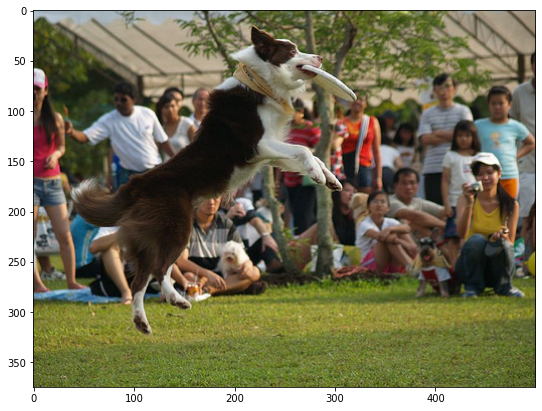

In [6]:
# Show image and 5 captions
plt.figure(figsize = (9,9))
plt.imshow(img)
print(df['caption'][5*100:5*101])

# Preprocess the caption

In [7]:
def caption_preprocessing(caption):

  # Remove punctuation from each token
  pattern = r'[^a-zA-z0-9\s]'
  caption = re.sub(pattern, '', caption)
  # Tokenize
  caption = caption.split()
  # Convert to lower
  caption = [word.lower() for word in caption]
  # Remove hanging "'s" and 'a'
  caption = [word for word in caption if len(word) > 1]
  # Remove tokens with number in them
  caption = [word for word in caption if word.isalpha()]

  # Store as string
  caption = ' '.join(caption)
  # Insert 'startseq' and 'endseq into caption
  caption = 'startseq ' + caption + ' endseq'

  return caption

In [8]:
# Example for caption preprocessing

print('Caption before processing: ')
print(df['caption'][2461])
print('Caption after processing: ')
print(caption_preprocessing(df['caption'][2461]))

Caption before processing: 
A group of children in blue uniforms walk to class .
Caption after processing: 
startseq group of children in blue uniforms walk to class endseq


In [9]:
# Preprocessing with all caption
df['caption'] = df['caption'].apply(caption_preprocessing)
print(df['caption'][2461])

startseq group of children in blue uniforms walk to class endseq


In [10]:
# Get images and captions like dict image1:[cap1, cap2, cap3, cap4, cap5]

def load_descriptions(df):
  mapping = dict()

  for i in range(len(df)):
    image_id = df['image'][i]

    if image_id not in mapping:
      mapping[image_id] = list()
    mapping[image_id].append(df['caption'][i])
    
  return mapping

image_dict = load_descriptions(df)
print('Loaded: %d ' % len(image_dict))

Loaded: 8091 


In [11]:
image_dict['1001773457_577c3a7d70.jpg']

['startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tricolored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [12]:
# Get training images name
df1 = pd.read_csv('./Flickr_8k.trainImages.txt')
training_image_names = set(df1['image'])

In [13]:
def subset_data_dict(image_dict, image_names):
  dict = {image_name:captions for image_name, captions in image_dict.items() if image_name in image_names}
  return (dict)

def all_captions(data_dict):
  return ([caption for key, captions in data_dict.items() for caption in captions])

def max_caption_length(captions):
  return max(len(caption.split()) for caption in captions)

def create_tokenizer(data_dict):
  captions = all_captions(data_dict)

  max_caption_words = max_caption_length(captions)
  
  # Initialise a Keras Tokenizer
  tokenizer = Tokenizer()
  
  # Fit it on the captions so that it prepares a vocabulary of all words
  tokenizer.fit_on_texts(captions)
  
  # Get the size of the vocabulary
  vocab_size = len(tokenizer.word_index) + 1

  return (tokenizer, vocab_size, max_caption_words)

In [14]:
training_dict = subset_data_dict(image_dict, training_image_names)

# Prepare tokenizer
tokenizer, vocab_size, max_caption_words = create_tokenizer(training_dict)

In [16]:
print(len(training_dict))
print(vocab_size)
print(max_caption_words)

6000
7579
34


In [17]:
def pad_text (text, max_length): 
  text = pad_sequences([text], maxlen = max_length, padding='post')[0]
  return (text)

# Preprocess the image using MobileNetV2

- Image size is 224x224

In [18]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
    return img, image_path

In [19]:
image_model = tf.keras.applications.MobileNetV2(include_top=False,weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

9420800/9406464 [==============================] - 0s 0us/step


In [20]:
training_image_paths = [image_path + name for name in training_image_names]
# Get unique images
encode_train = sorted(set(training_image_paths))
print(encode_train[0])

./Net/1000268201_693b08cb0e.jpg


In [ ]:
# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 375/375 [19:02<00:00,  3.05s/it]


# Prepare Training Data using a Tensorflow Dataset

In [21]:
def data_pre(data_dict, tokenizer, max_length, vocab_size):
  X, y = list(), list()

  # For each image and list of captions
  for image_name, captions in data_dict.items():
    image_name = image_path + image_name

    # For each caption in list of captions
    for caption in captions:

      # Convert the caption word into a list of word indices
      word_idxs = tokenizer.texts_to_sequences([caption])[0]

      # Pad the input text to the same fixed length
      pad_idxs = pad_text(word_idxs, max_length)

      X.append(image_name)
      y.append(pad_idxs)
  
  return np.array(X), np.array(y)
  return X, y

train_X, train_y = data_pre(training_dict, tokenizer, max_caption_words, vocab_size)

In [22]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]),num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Image Caption Model with Attention and GRU

## Model

Fun fact: the decoder below is identical to the one in the example for [Neural Machine Translation with Attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention).

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (7, 7, 1280).
* You squash that to a shape of (49, 1280).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here GRU) attends over the image to predict the next word.

In [23]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]),num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [24]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 49, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 49, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 49, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 49, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [25]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 49, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [26]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform',
                                   kernel_regularizer=tf.keras.regularizers.l2(1e-8))
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)
  
  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [27]:
embedding_dim = 256
units = 512
vocab_size = vocab_size
num_steps = len(train_X) // BATCH_SIZE
# Shape of the vector extracted from MobilenetV2 is (49, 1280)
# These two variables represent that vector shape
features_shape = 1280
attention_features_shape = 49

encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [28]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [29]:
checkpoint_path = "/content/drive/MyDrive/045195/Image Captioning/checkpoints1/GRU_attention/"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=20)

In [30]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

* You extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [ ]:
loss_plot = []
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['startseq']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
import time
start_epoch = 0
EPOCHS = 50

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)
    
    if (epoch+1) % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 2.8926
Epoch 1 Batch 100 Loss 1.5814
Epoch 1 Batch 200 Loss 1.4307
Epoch 1 Batch 300 Loss 1.2653
Epoch 1 Batch 400 Loss 1.2456
Epoch 1 Loss 1.424802
Time taken for 1 epoch 230.82 sec

Epoch 2 Batch 0 Loss 1.1247
Epoch 2 Batch 100 Loss 1.2111
Epoch 2 Batch 200 Loss 1.1869
Epoch 2 Batch 300 Loss 1.0632
Epoch 2 Batch 400 Loss 1.1879
Epoch 2 Loss 1.109075
Time taken for 1 epoch 145.01 sec

Epoch 3 Batch 0 Loss 1.1055
Epoch 3 Batch 100 Loss 0.9156
Epoch 3 Batch 200 Loss 1.0496
Epoch 3 Batch 300 Loss 0.9625
Epoch 3 Batch 400 Loss 0.8885
Epoch 3 Loss 0.987074
Time taken for 1 epoch 144.67 sec

Epoch 4 Batch 0 Loss 0.9342
Epoch 4 Batch 100 Loss 0.9143
Epoch 4 Batch 200 Loss 0.8811
Epoch 4 Batch 300 Loss 0.9206
Epoch 4 Batch 400 Loss 0.8312
Epoch 4 Loss 0.897912
Time taken for 1 epoch 143.85 sec

Epoch 5 Batch 0 Loss 0.9132
Epoch 5 Batch 100 Loss 0.7177
Epoch 5 Batch 200 Loss 0.8839
Epoch 5 Batch 300 Loss 0.8256
Epoch 5 Batch 400 Loss 0.7825
Epoch 5 Loss 0.825916
Time taken

In [ ]:
import time
start_epoch = 36
EPOCHS = 50

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)
    
    if (epoch+1) % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 37 Batch 0 Loss 0.2342
Epoch 37 Batch 100 Loss 0.2436
Epoch 37 Batch 200 Loss 0.2371
Epoch 37 Batch 300 Loss 0.2212
Epoch 37 Batch 400 Loss 0.2258
Epoch 37 Loss 0.227574
Time taken for 1 epoch 1015.14 sec

Epoch 38 Batch 0 Loss 0.2252
Epoch 38 Batch 100 Loss 0.2330
Epoch 38 Batch 200 Loss 0.2086
Epoch 38 Batch 300 Loss 0.2280
Epoch 38 Batch 400 Loss 0.2489
Epoch 38 Loss 0.224413
Time taken for 1 epoch 154.26 sec

Epoch 39 Batch 0 Loss 0.2231
Epoch 39 Batch 100 Loss 0.2306
Epoch 39 Batch 200 Loss 0.1889
Epoch 39 Batch 300 Loss 0.2289
Epoch 39 Batch 400 Loss 0.1913
Epoch 39 Loss 0.221411
Time taken for 1 epoch 158.00 sec

Epoch 40 Batch 0 Loss 0.1991
Epoch 40 Batch 100 Loss 0.2260
Epoch 40 Batch 200 Loss 0.2119
Epoch 40 Batch 300 Loss 0.1993
Epoch 40 Batch 400 Loss 0.2123
Epoch 40 Loss 0.217376
Time taken for 1 epoch 157.10 sec

Epoch 41 Batch 0 Loss 0.2183
Epoch 41 Batch 100 Loss 0.2090
Epoch 41 Batch 200 Loss 0.2204
Epoch 41 Batch 300 Loss 0.2055
Epoch 41 Batch 400 Loss 0.2214
Ep

In [ ]:
loss_plot = [1.424802,1.109075,0.987074,0.897912,0.825916,0.765434,0.710464,0.663264,0.621364,0.582809,0.547679,0.516711,0.486844,0.460628,0.436413,0.414224,0.393938,0.376177,0.360594,0.344458,0.330892,0.318344,0.309775,0.300903,0.288475,0.279695,0.271904,0.263679,0.258792,0.253933,0.247191,0.242527,0.238839,0.234505,0.230260,0.227574,0.224413,0.221411,0.217376,0.214678,0.214514,0.211269,0.207486,0.205612,0.204213,0.203406,0.201772,0.199638,0.198672]

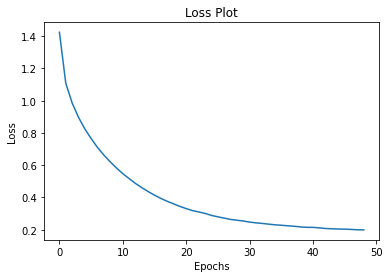

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Evaluate

In [31]:
def evaluate(image, max_length):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['startseq']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == 'endseq':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [32]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: ['startseq blonde woman in black jeans is sitting on wall examining her nails endseq', 'startseq woman in black jeans sits on the railing of bridge with harbor in the background endseq', 'startseq young woman sitting on ledge with black purse looking at her finger nails endseq', 'startseq girl sitting on wall looking at her nails endseq', 'startseq the girl has black purse and is sitting on the side of ledge endseq']
Prediction Caption: young woman is climbing the concrete wall endseq


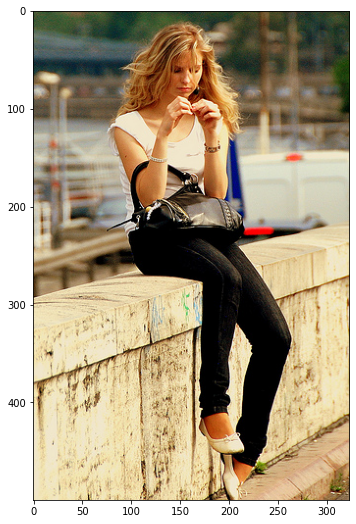

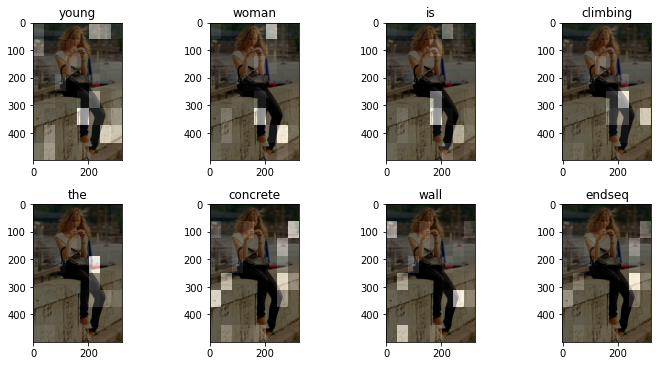

In [ ]:
def check_test(test_image_names, image_dict, image_dir, max_caption_words):
  # captions on the validation set
  rid = np.random.randint(0, len(test_image_names))
  image_name = test_image_names[rid]
  real_caption = image_dict[image_name]

  image_path = image_dir + image_name
  result, attention_plot = evaluate(image_path, max_caption_words)

  #from IPython.display import Image, display
  #display(Image(image_path))
  print('Real Caption:', real_caption)
  print('Prediction Caption:', ' '.join(result))

  image_name = './Net/' + image_name
  img = Image.open(image_name)
  plt.figure(figsize = (9,9))
  plt.imshow(img)
  plot_attention(image_name, result, attention_plot)
  
df2 = pd.read_csv( "./Flickr_8k.testImages.txt")
test_image_names = set(df2['image'])
image_dir = image_path
check_test(list(test_image_names), image_dict, image_dir, max_caption_words)

Real Caption: ['startseq group of skiers going up mountain endseq', 'startseq four crosscountry skiers climb uphill endseq', 'startseq four people climbing hill in the snow endseq', 'startseq four skiers walking up snow covered hill endseq', 'startseq four skiers climbing snow drapped mountain endseq']
Prediction Caption: two men are skiing on the snowy trail endseq


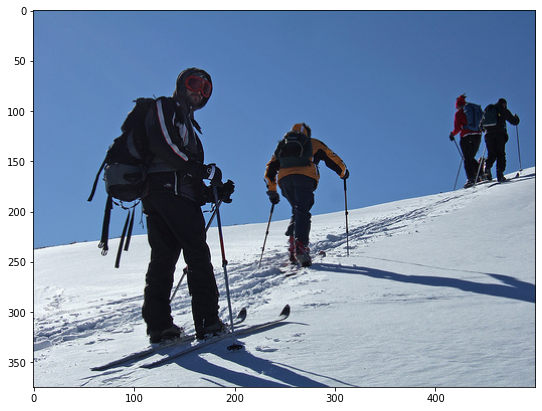

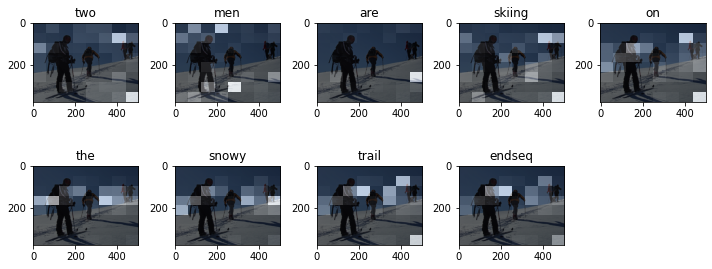

In [ ]:
check_test(list(test_image_names), image_dict, image_dir, max_caption_words)

Real Caption: ['startseq snowboarder is doing flip over mound of snow endseq', 'startseq snowboarder is in midair doing trick endseq', 'startseq somebody in the air on board endseq', 'startseq someone on rooftop jumping on some sort of board caught in midair endseq', 'startseq there is person on snowboard up high in the air endseq']
Prediction Caption: woman is flipping ramp and another hiker jumps into the blue sky endseq


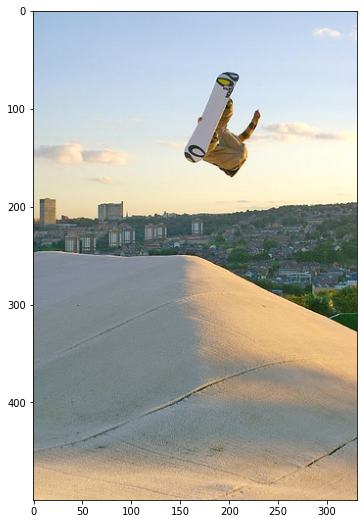

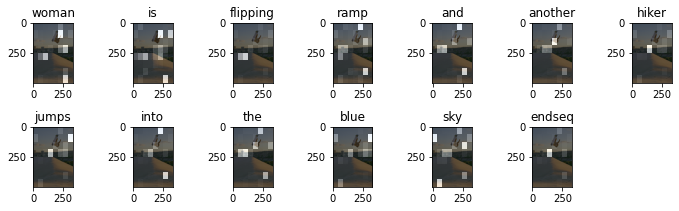

In [ ]:
check_test(list(test_image_names), image_dict, image_dir, max_caption_words)

Real Caption: ['startseq person floats in water near rocks and waterfall endseq', 'startseq person swimming in pretty lake with waterfall in the background endseq', 'startseq person swimming in water nearby rocks and small waterfall endseq', 'startseq person swims in body of water with waterfall endseq', 'startseq person swims in pool by waterfall endseq']
Prediction Caption: person in blue water endseq


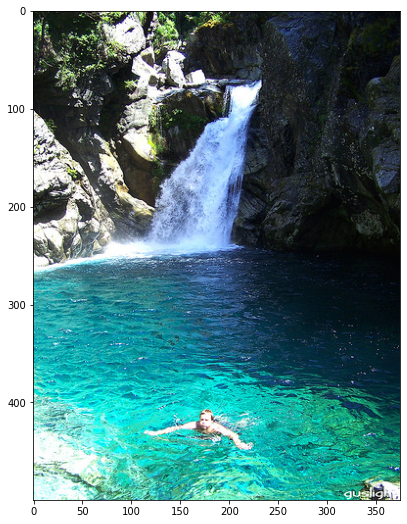

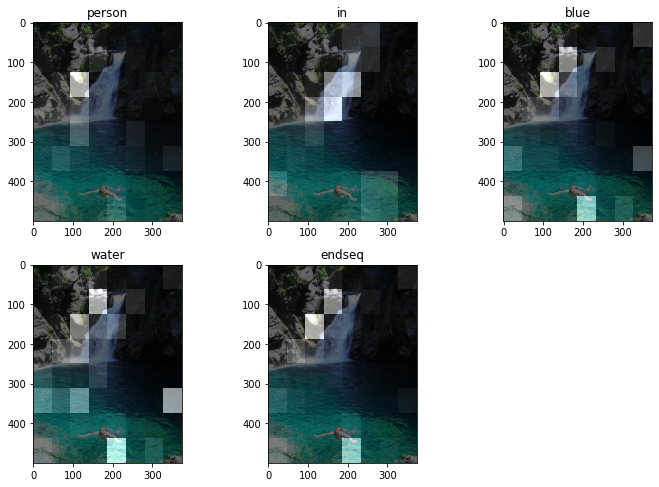

In [ ]:
check_test(list(test_image_names), image_dict, image_dir, max_caption_words)

In [38]:
import nltk.translate.bleu_score as bleu
from nltk.translate.bleu_score import SmoothingFunction

smoothie = SmoothingFunction().method4

def bleu_score(test_image_names, image_dict, image_dir, max_caption_words):
  # captions on the validation set
  bleu_score = []
  for id in range(len(test_image_names)):
  # for id in range(10):
    image_name = test_image_names[id]
    real_caption = image_dict[image_name]
    image_path = image_dir + image_name
    result = evaluate(image_path, max_caption_words)
    
    reference_translation = [str(real_caption[0]).split(),
                             str(real_caption[1]).split(),
                             str(real_caption[2]).split(),
                             str(real_caption[3]).split(),
                             str(real_caption[4]).split()
                            ]
    candidate_translation = result[0]
    
    score = bleu.sentence_bleu(reference_translation, candidate_translation, smoothing_function=smoothie)
    # print(candidate_translation)
    #print(reference_translation)
    # print(score)
    bleu_score.append(score)
  
  bleu_score_avg = sum(bleu_score) / len(bleu_score)
  return bleu_score_avg

score = bleu_score(list(test_image_names), image_dict, image_dir, max_caption_words)
print(score)

0.21793458640384705


# Image Caption Model with Attention and LSTM

## Model

In [39]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]),num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [40]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 49, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 49, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 49, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 49, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [41]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 49, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [42]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

    self.rnn = tf.keras.layers.LSTM(self.units, 
                                    return_sequences=True, 
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform',
                                    kernel_regularizer=tf.keras.regularizers.l2(1e-8))


    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)
  
  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the LSTM
    output, state, _ = self.rnn(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [43]:
embedding_dim = 256
units = 512
vocab_size = vocab_size
num_steps = len(train_X) // BATCH_SIZE
# Shape of the vector extracted from MobilenetV2 is (49, 1280)
# These two variables represent that vector shape
features_shape = 1280
attention_features_shape = 49

encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [44]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [45]:
checkpoint_path = "/content/drive/MyDrive/045195/Image Captioning/checkpoints1/LSTM_attention/"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [46]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

In [ ]:
loss_plot = []
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['startseq']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
import time
start_epoch = 0
EPOCHS = 50

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)
    
    if (epoch+1) % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 2.6070
Epoch 1 Batch 100 Loss 1.7718
Epoch 1 Batch 200 Loss 1.5576
Epoch 1 Batch 300 Loss 1.2388
Epoch 1 Batch 400 Loss 1.2854
Epoch 1 Loss 1.495736
Time taken for 1 epoch 244.19 sec

Epoch 2 Batch 0 Loss 1.2974
Epoch 2 Batch 100 Loss 1.1345
Epoch 2 Batch 200 Loss 1.2079
Epoch 2 Batch 300 Loss 1.1351
Epoch 2 Batch 400 Loss 1.0259
Epoch 2 Loss 1.122262
Time taken for 1 epoch 153.18 sec

Epoch 3 Batch 0 Loss 1.1292
Epoch 3 Batch 100 Loss 0.9268
Epoch 3 Batch 200 Loss 1.0277
Epoch 3 Batch 300 Loss 0.9186
Epoch 3 Batch 400 Loss 1.0423
Epoch 3 Loss 0.995417
Time taken for 1 epoch 153.23 sec

Epoch 4 Batch 0 Loss 1.0155
Epoch 4 Batch 100 Loss 0.8772
Epoch 4 Batch 200 Loss 1.0176
Epoch 4 Batch 300 Loss 0.8586
Epoch 4 Batch 400 Loss 0.8502
Epoch 4 Loss 0.906945
Time taken for 1 epoch 153.35 sec

Epoch 5 Batch 0 Loss 0.8446
Epoch 5 Batch 100 Loss 0.7894
Epoch 5 Batch 200 Loss 0.8458
Epoch 5 Batch 300 Loss 0.8359
Epoch 5 Batch 400 Loss 0.8468
Epoch 5 Loss 0.833210
Time taken

In [ ]:
loss_plot = [1.495736,1.122262,0.995417,0.906945,0.833210,0.769289,0.711543,0.661055,0.614461,0.572101,0.533063,0.498039,0.466565,0.437353,0.411052,0.387914,0.374802,0.350540,0.330461,0.316764,0.302181,0.290669,0.280699,0.270879,0.261996,0.256013,0.248590,0.242144,0.238022,0.230848,0.226885,0.223785,0.219104,0.215386,0.213739,0.210265,0.207212,0.204001,0.202719,0.199591,0.197615,0.196462,0.194266,0.193432]

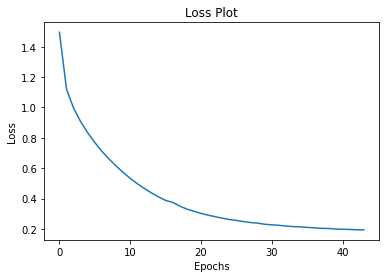

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Evaluate

In [47]:
def evaluate(image, max_length):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['startseq']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == 'endseq':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [48]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: ['startseq boy sitting in water endseq', 'startseq small boy is sitting in the water and water is splashing up through his legs endseq', 'startseq young boy in swimming suit sits in water endseq', 'startseq young boy sitting on water jet in pool endseq', 'startseq little boy sitting in water with fountain coming up through his lap endseq']
Prediction Caption: young boy playing in the water endseq


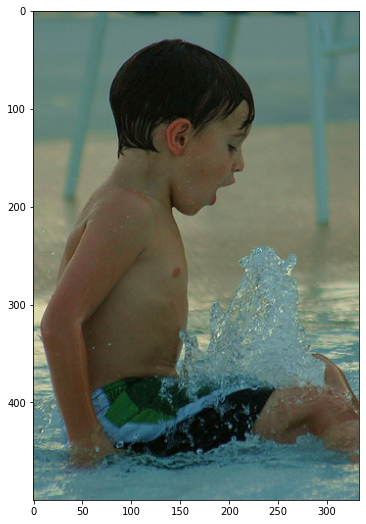

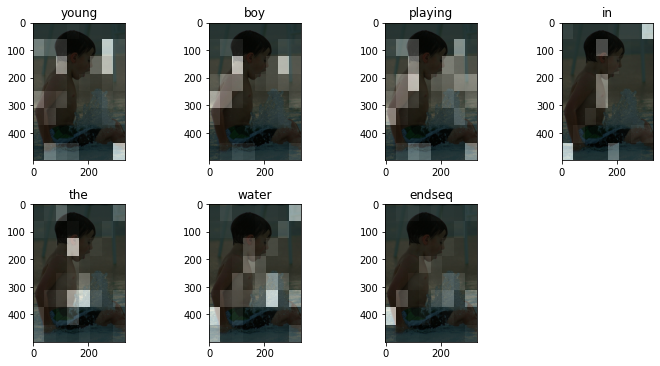

In [ ]:
def check_test(test_image_names, image_dict, image_dir, max_caption_words):
  # captions on the validation set
  rid = np.random.randint(0, len(test_image_names))
  image_name = test_image_names[rid]
  real_caption = image_dict[image_name]

  image_path = image_dir + image_name
  result, attention_plot = evaluate(image_path, max_caption_words)

  #from IPython.display import Image, display
  #display(Image(image_path))
  print('Real Caption:', real_caption)
  print('Prediction Caption:', ' '.join(result))

  image_name = './Net/' + image_name
  img = Image.open(image_name)
  plt.figure(figsize = (9,9))
  plt.imshow(img)
  plot_attention(image_name, result, attention_plot)

  
df2 = pd.read_csv( "./Flickr_8k.testImages.txt")
test_image_names = set(df2['image'])
image_dir = image_path
check_test(list(test_image_names), image_dict, image_dir, max_caption_words)

Real Caption: ['startseq man surfing wave endseq', 'startseq surfer in wetsuite jumps waves endseq', 'startseq surfer is riding his board over wave endseq', 'startseq surfer on white board catches wave endseq', 'startseq the man turns with the wave on his surfboard endseq']
Prediction Caption: man is wakeboarding on huge ocean wave endseq


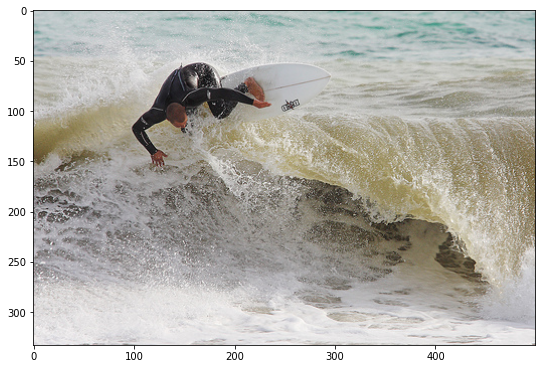

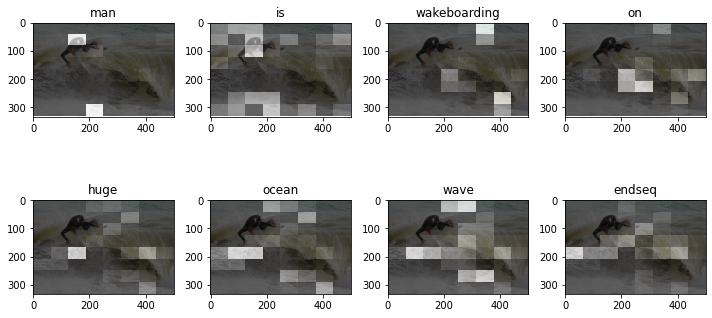

In [ ]:
check_test(list(test_image_names), image_dict, image_dir, max_caption_words)

Real Caption: ['startseq dog walks down the dirt road as person follows endseq', 'startseq tan dog walks ahead of man in dry area endseq', 'startseq white dog is going for walk through the desert with its owner endseq', 'startseq yellow dog is walking along mountain trail endseq', 'startseq dog in desert area with distant man in background endseq']
Prediction Caption: the brown dog is running next to another dog endseq


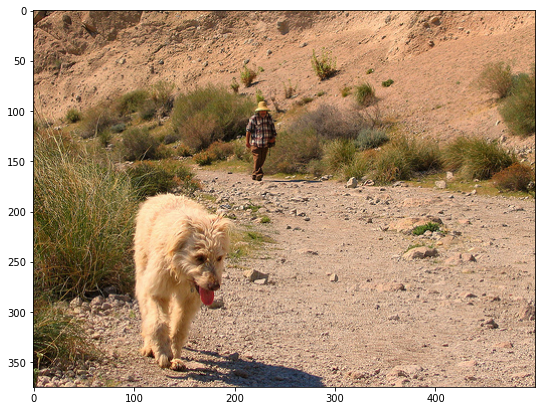

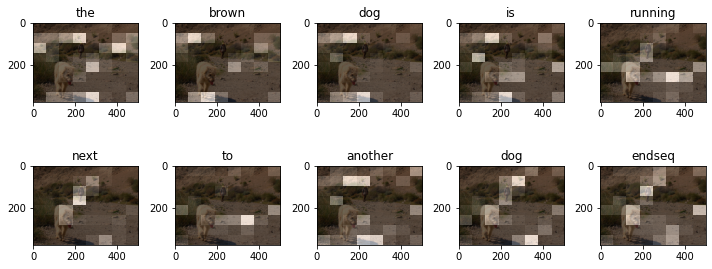

In [ ]:
check_test(list(test_image_names), image_dict, image_dir, max_caption_words)

In [52]:
import nltk.translate.bleu_score as bleu
from nltk.translate.bleu_score import SmoothingFunction

smoothie = SmoothingFunction().method4

def bleu_score(test_image_names, image_dict, image_dir, max_caption_words):
  # captions on the validation set
  bleu_score = []
  for id in range(len(test_image_names)):
  # for id in range(10):
    image_name = test_image_names[id]
    real_caption = image_dict[image_name]
    image_path = image_dir + image_name
    result = evaluate(image_path, max_caption_words)
    
    reference_translation = [str(real_caption[0]).split(),
                             str(real_caption[1]).split(),
                             str(real_caption[2]).split(),
                             str(real_caption[3]).split(),
                             str(real_caption[4]).split()
                            ]
    candidate_translation = result[0]
    
    score = bleu.sentence_bleu(reference_translation, candidate_translation, smoothing_function=smoothie)
    # print(result)
    #print(reference_translation)
    # print(score)
    bleu_score.append(score)
  
  bleu_score_avg = sum(bleu_score) / len(bleu_score)
  return bleu_score_avg

score = bleu_score(list(test_image_names), image_dict, image_dir, max_caption_words)
print(score)

0.2209443544222325


# Try with my image using Model with Attention and LSTM, Mobilenetv2

Prediction Caption: group of children are walking through the woods endseq


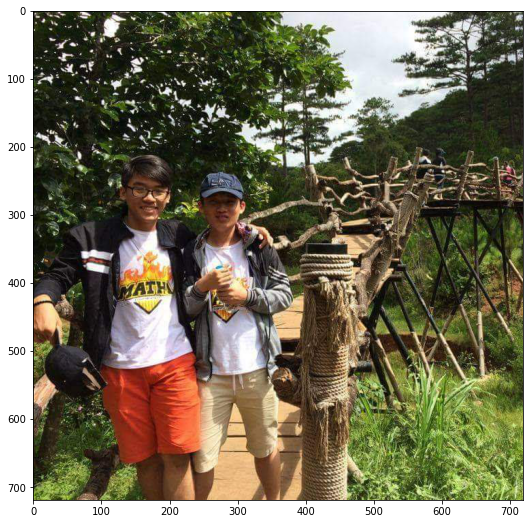

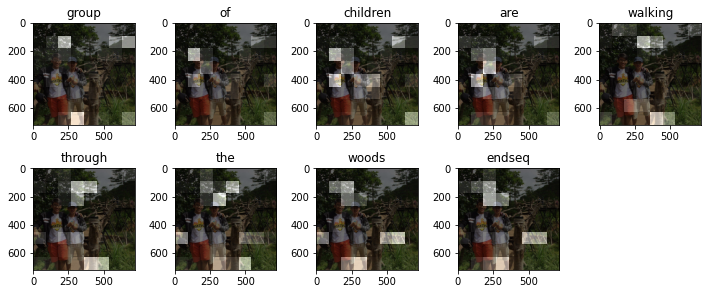

In [63]:
image_path = '/content/drive/MyDrive/045195/Image Captioning/Image.jpg'

result, attention_plot = evaluate(image_path, max_caption_words)
print('Prediction Caption:', ' '.join(result))
img = Image.open(image_path)
plt.figure(figsize = (9,9))
plt.imshow(img)
plot_attention(image_path, result, attention_plot)
# opening the image